In [3]:
pip install -r requirements.txt

  Using cached pandas-2.2.2-cp39-cp39-macosx_11_0_arm64.whl.metadata (19 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 16.5 MB/s eta 0:00:00m eta 0:00:010:0101
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 18.5 MB/s eta 0:00:00m eta 0:00:010:0101
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 19.8 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.3/30.3 MB 18.6 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 12.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Function to read and vectorize the log file
def vectorize_log_file(file_path):
    with open(file_path, 'r') as file:
        log_content = file.read()
    vectorizer = TfidfVectorizer()
    log_vector = vectorizer.fit_transform([log_content])
    return log_vector.toarray()[0], vectorizer

# Function to parse execution trace
def parse_execution_trace(file_path):
    with open(file_path, 'r') as file:
        trace_lines = file.readlines()
    trace_data = []
    for line in trace_lines:
        parts = line.strip().split(',')
        if len(parts) == 6:
            trace_data.append(parts)
    return pd.DataFrame(trace_data, columns=['signature', 'test_trace_id', 'line_no', 'registry_id', 'path', 'invoked_order'])

# Function to vectorize execution trace
def vectorize_execution_trace(trace_df, unique_methods):
    trace_vector = [1 if method in trace_df['signature'].values else 0 for method in unique_methods]
    return trace_vector


In [6]:
# Define the paths to your training log files and execution traces
train_log_files = ["trace.log"]
train_trace_files = ["trace_data.csv"]

log_vectors = []
execution_vectors = []
all_signatures = set()

# Load and vectorize the log files and execution traces for training
for log_file, trace_file in zip(train_log_files, train_trace_files):
    log_vector, vectorizer = vectorize_log_file(log_file)
    log_vectors.append(log_vector)
    
    trace_df = parse_execution_trace(trace_file)
    unique_methods = trace_df['signature'].unique()
    all_signatures.update(unique_methods)
    trace_vector = vectorize_execution_trace(trace_df, unique_methods)
    execution_vectors.append(trace_vector)

# Ensure all execution vectors are the same length
unique_methods = sorted(list(all_signatures))
fixed_execution_vectors = []
for vector in execution_vectors:
    fixed_vector = [1 if method in unique_methods else 0 for method in unique_methods]
    fixed_execution_vectors.append(fixed_vector)

# Combine all log vectors and execution vectors into single datasets
X_train = pd.DataFrame(log_vectors)
y_train = pd.DataFrame(fixed_execution_vectors)

# Train the Random Forest model
model = RandomForestClassifier()
model.fit(X_train, y_train)


RandomForestClassifier()

In [7]:
model

RandomForestClassifier()

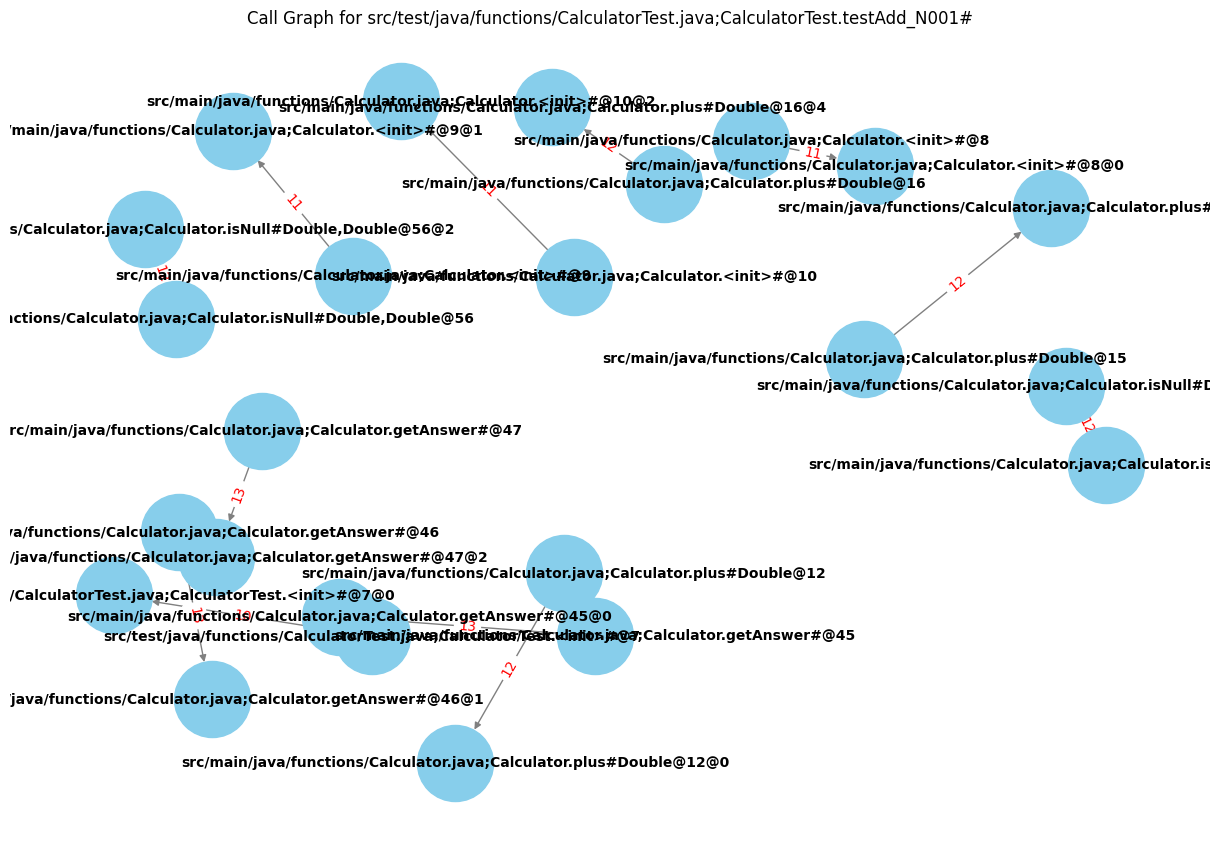

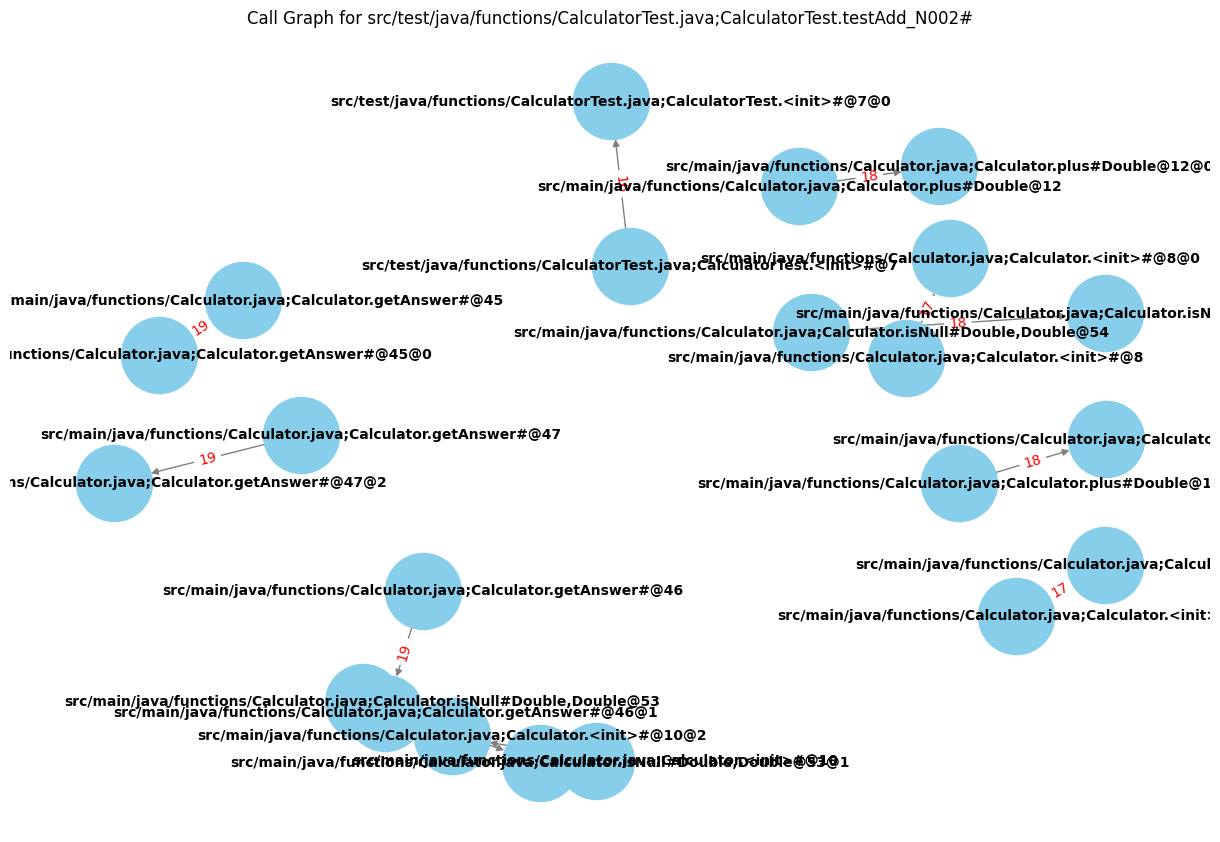

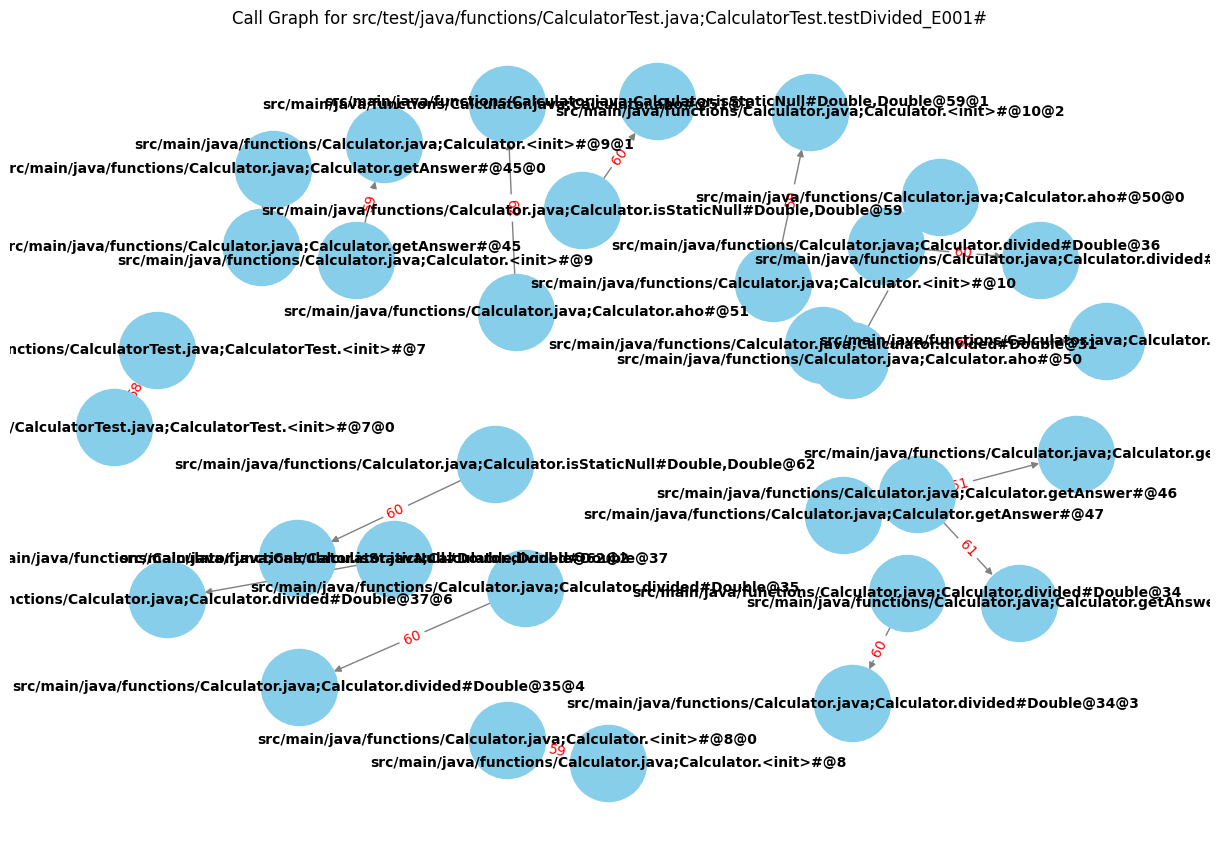

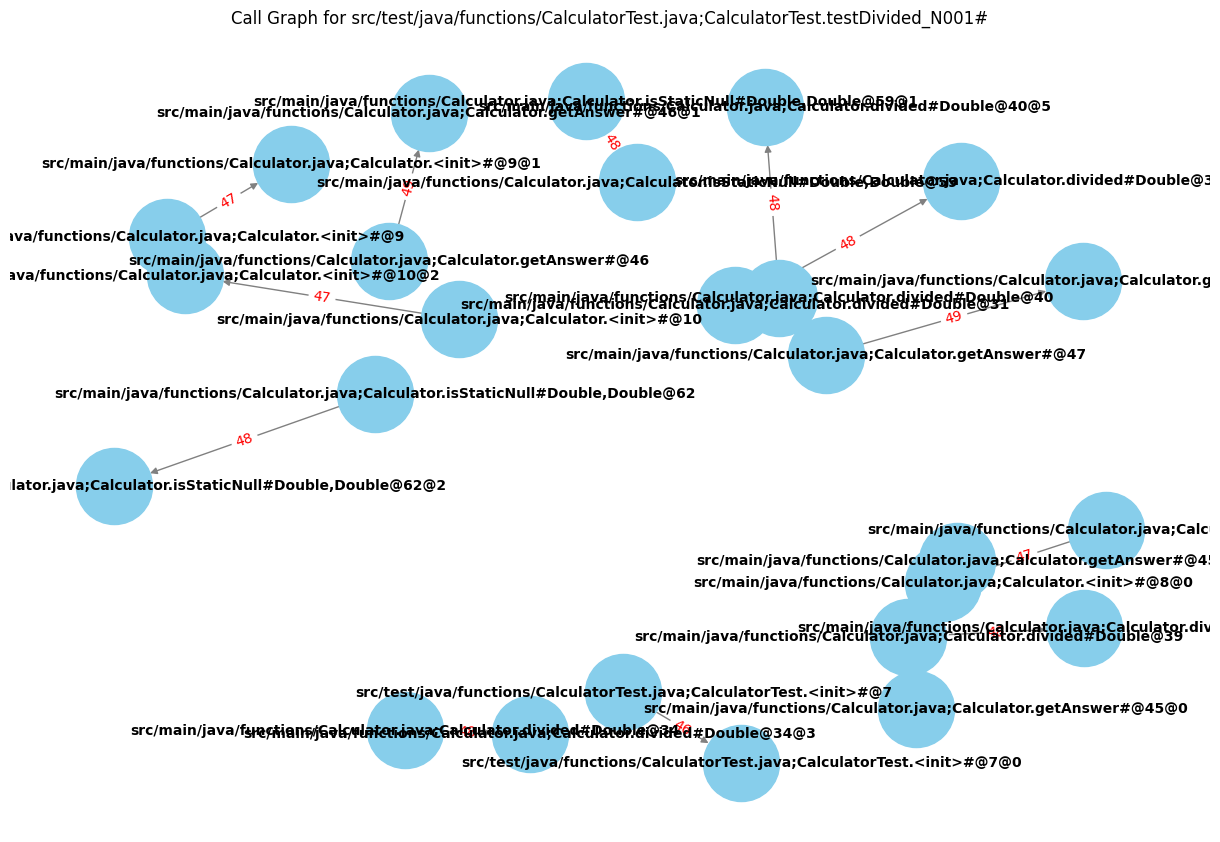

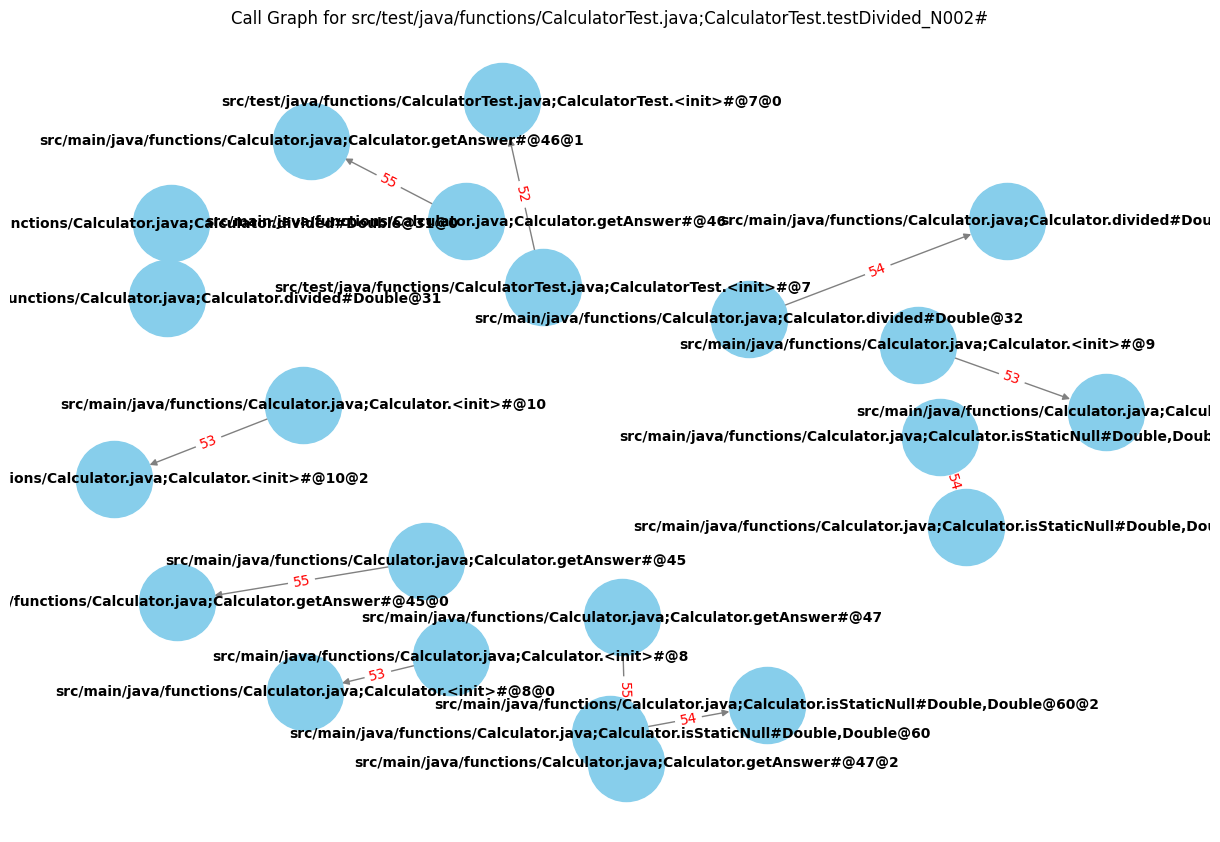

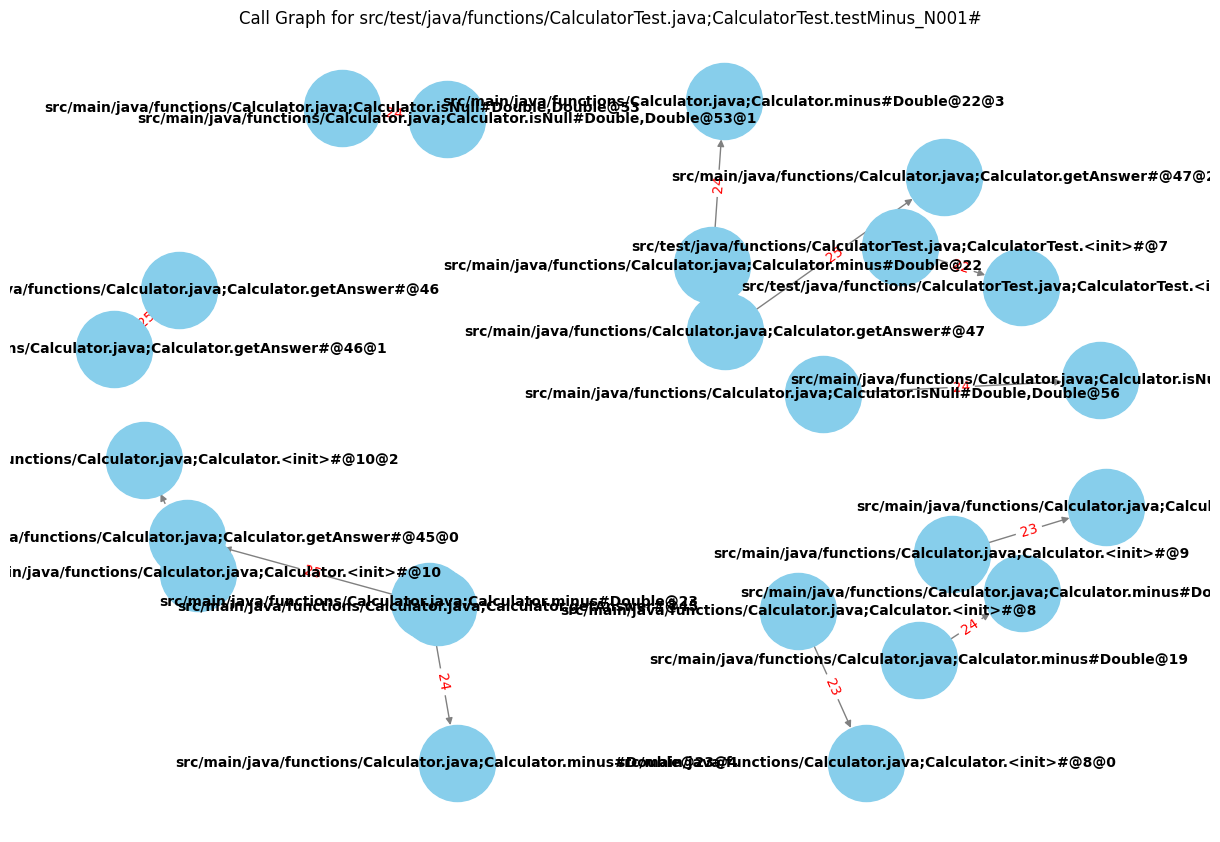

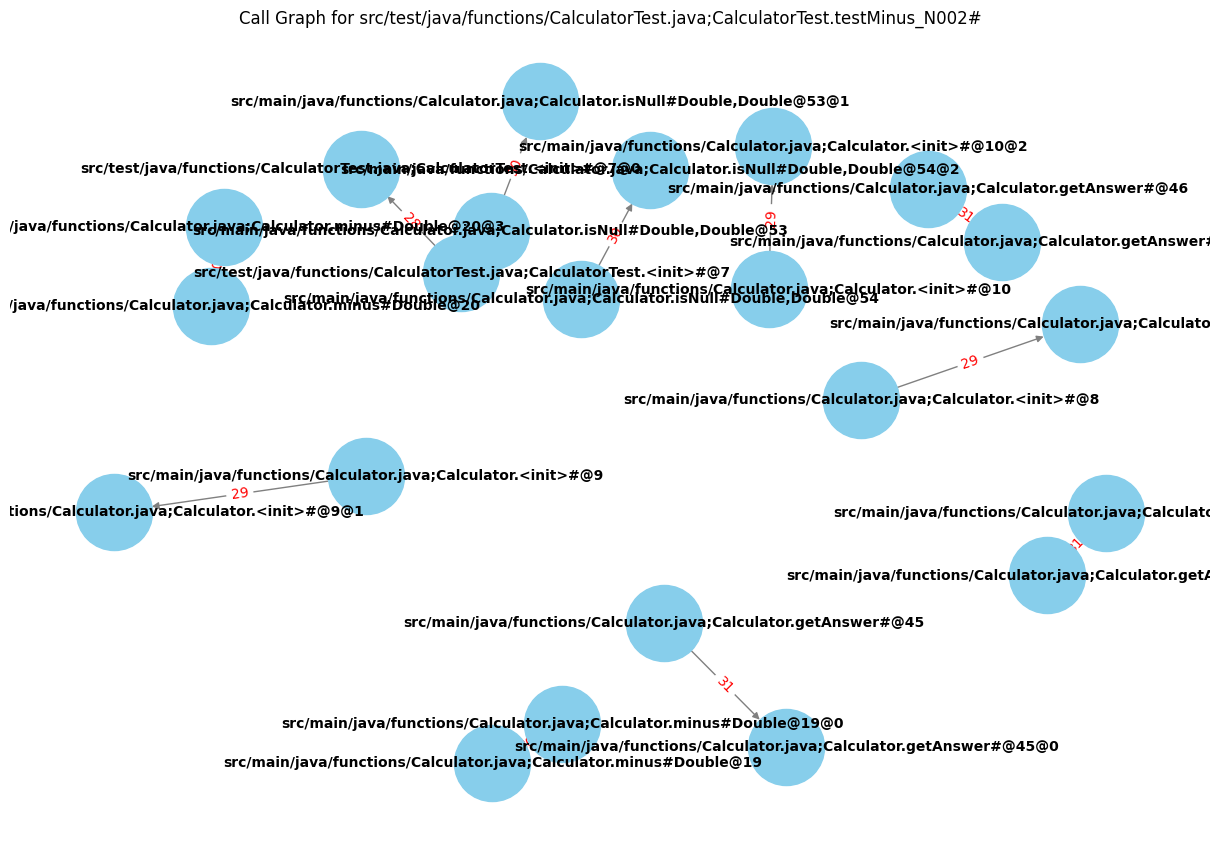

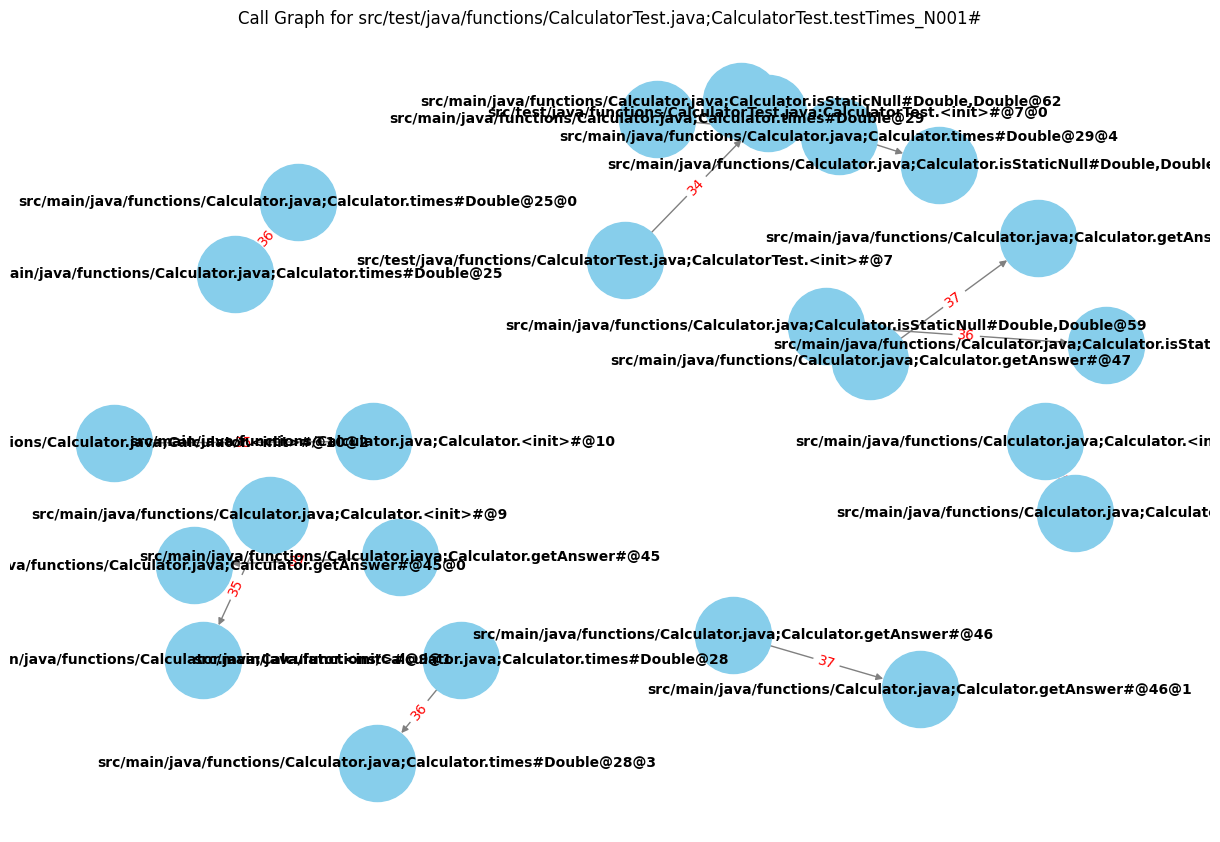

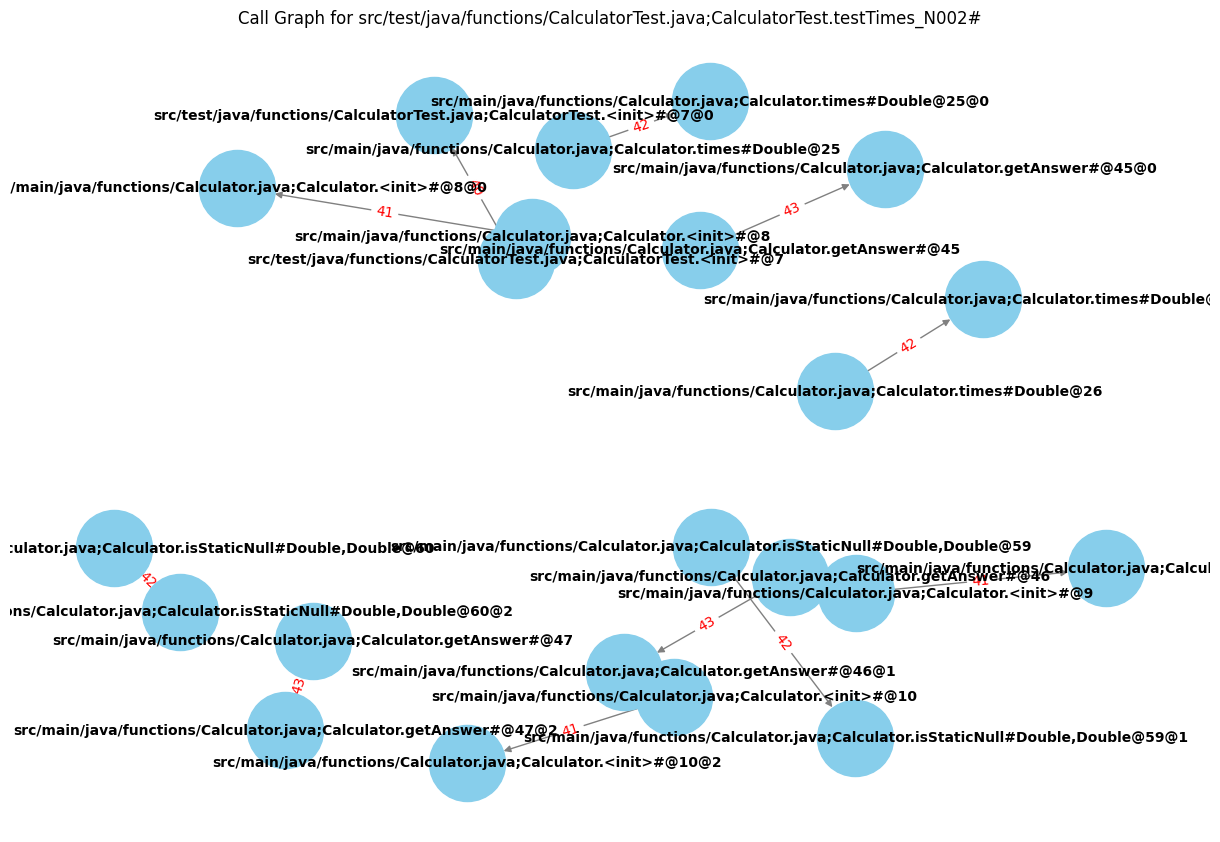

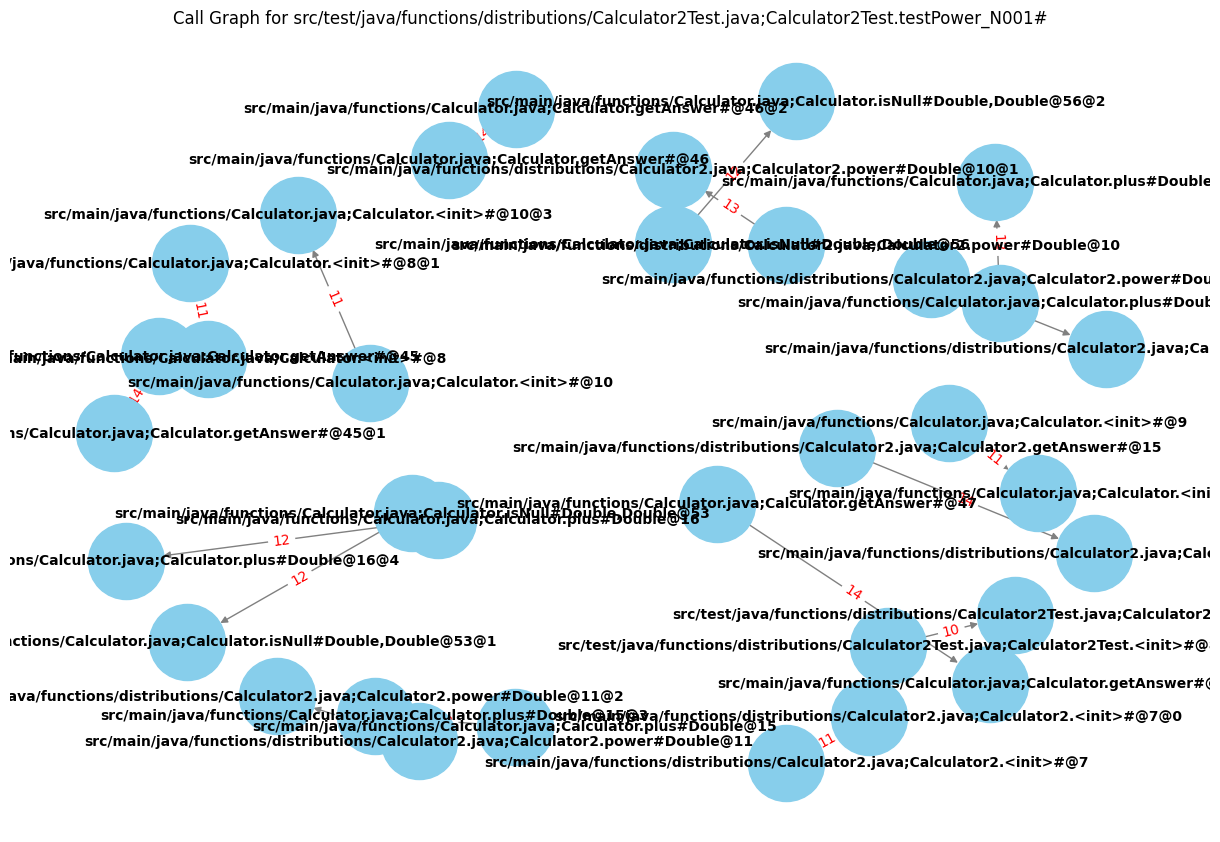

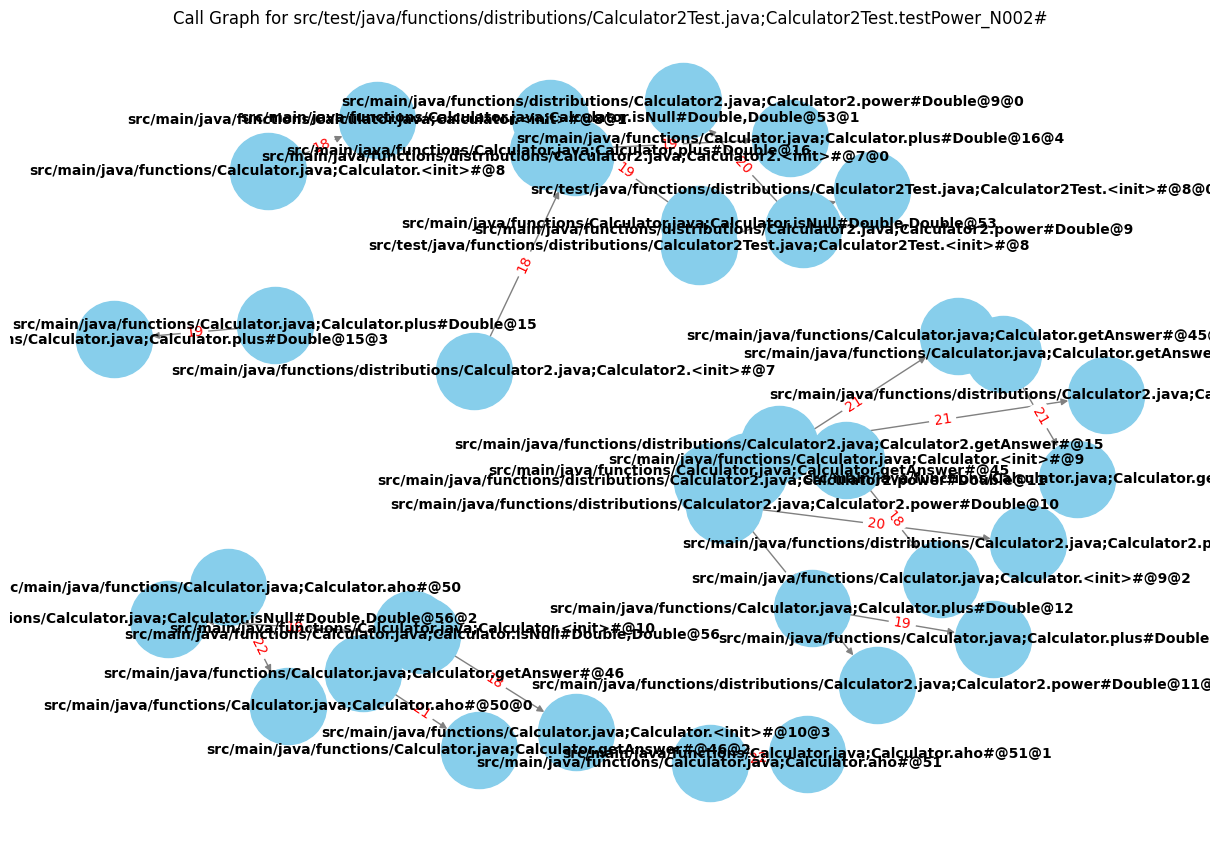

In [10]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load the trace data into a DataFrame
data = pd.read_csv("trace_data.csv")

# Process the data to group by test cases
grouped_data = data.groupby("signature")

# Function to create a directed graph for each test case
def create_graph(group):
    G = nx.DiGraph()
    for _, row in group.iterrows():
        src = row['path']
        dst = f"{row['path']}@{row['invoked_order']}"
        G.add_edge(src, dst, line_no=row['line_no'])
    return G

# Create a plot for each test case
for signature, group in grouped_data:
    G = create_graph(group)
    
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", edge_color="gray")
    edge_labels = {(u, v): d['line_no'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")
    plt.title(f"Call Graph for {signature}")
    plt.show()


In [9]:
pip install networkx matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.6 MB/s eta 0:00:0031m13.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 15.8 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.0/245.0 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.9 MB/s eta 0:00:0031m19.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 19.4 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 12.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [12]:
trace_df.signature.unique()

array(['"signature"',
       '"src/test/java/functions/CalculatorTest.java;CalculatorTest.testAdd_N001#"',
       '"src/test/java/functions/CalculatorTest.java;CalculatorTest.testAdd_N002#"',
       '"src/test/java/functions/CalculatorTest.java;CalculatorTest.testDivided_E001#"',
       '"src/test/java/functions/CalculatorTest.java;CalculatorTest.testDivided_N001#"',
       '"src/test/java/functions/CalculatorTest.java;CalculatorTest.testDivided_N002#"',
       '"src/test/java/functions/CalculatorTest.java;CalculatorTest.testMinus_N001#"',
       '"src/test/java/functions/CalculatorTest.java;CalculatorTest.testMinus_N002#"',
       '"src/test/java/functions/CalculatorTest.java;CalculatorTest.testTimes_N001#"',
       '"src/test/java/functions/CalculatorTest.java;CalculatorTest.testTimes_N002#"',
       '"src/test/java/functions/distributions/Calculator2Test.java;Calculator2Test.testPower_N001#"',
       '"src/test/java/functions/distributions/Calculator2Test.java;Calculator2Test.testPo

In [30]:
trace_df[trace_df['signature'] == trace_df['signature'].unique()[1]]

'"src/test/java/functions/CalculatorTest.java;CalculatorTest.testAdd_N001#"'

In [24]:
trace_df['signature'][10]


'"src/test/java/functions/CalculatorTest.java;CalculatorTest.testAdd_N001#"'

In [31]:
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Function to read and vectorize the log file
def vectorize_log_file(file_path, vectorizer=None, fit=True):
    with open(file_path, 'r') as file:
        log_content = file.read()
    if fit:
        log_vector = vectorizer.fit_transform([log_content])
    else:
        log_vector = vectorizer.transform([log_content])
    return log_vector.toarray()[0]

# Function to parse execution trace
def parse_execution_trace(file_path):
    with open(file_path, 'r') as file:
        trace_lines = file.readlines()
    trace_data = []
    for line in trace_lines:
        parts = line.strip().split(',')
        if len(parts) == 6:
            trace_data.append(parts)
    return pd.DataFrame(trace_data, columns=['signature', 'test_trace_id', 'line_no', 'registry_id', 'path', 'invoked_order'])

# Function to vectorize execution trace for each method
def vectorize_execution_trace(trace_df, unique_methods):
    execution_vectors = {}
    for method in unique_methods:
        method_trace = trace_df[trace_df['signature'] == method]
        method_vector = [1 if row['line_no'] in method_trace['line_no'].values else 0 for _, row in trace_df.iterrows()]
        execution_vectors[method] = method_vector
    return execution_vectors
